## Drone Localisation Simulation
This project is setup to test the simulation of a microphone picking up the sounds of a drone for the purposes of localisation.



In [2]:
!pip install pyroomacoustics numpy scipy==1.11.1 matplotlib acoular

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
from numpy import hamming
from scipy.io import wavfile
from IPython.display import Audio, display
from math import floor
import acoular

## Building the Space

This is where we specify the dimensions of our simulation environment.

In [9]:
corner_locs = 150.0
metric_conv = 0.3048

corners = np.array(
    [
        [0.0,0.0],
        [corner_locs,0.0],
        [corner_locs,corner_locs],
        [0.0,corner_locs]
    ]
).T
h = 9.5

# Convert to metric
h *= 0.3048
corners *= 0.3048

# Generate the source and the mics
source = np.array([[122.45], [122], [4.0]])
source_noise = np.array([[114], [114], [2.0]])
mic_locs = np.c_[
    [2, 5, 1.2], [5, 2, 1.2], [5, 5, 1.2],   # mic 1  # mic 2  # mic 3
]

# Convert to metric
corner_locs *= metric_conv
source *= metric_conv
source_noise *= metric_conv
mic_locs *= metric_conv

# Get FS
fs, s = wavfile.read("drone_audio.wav")

## Displaying the Space

(-1.0, 46.72)

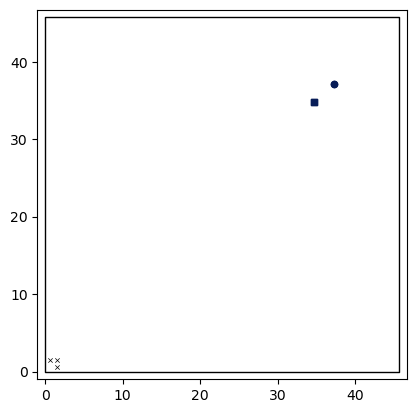

In [10]:
# Display the Space in 2D
room = pra.Room.from_corners(corners)
room.add_source(source[:2])
room.add_source(source_noise[:2])
room.add_microphone_array(pra.MicrophoneArray(mic_locs[:2,:], fs=fs))

fig, ax = room.plot(img_order=2)
ax.set_xlim([-1, 1 + corner_locs])
ax.set_ylim([-1, 1 + corner_locs])


The RT60 is 6 ms


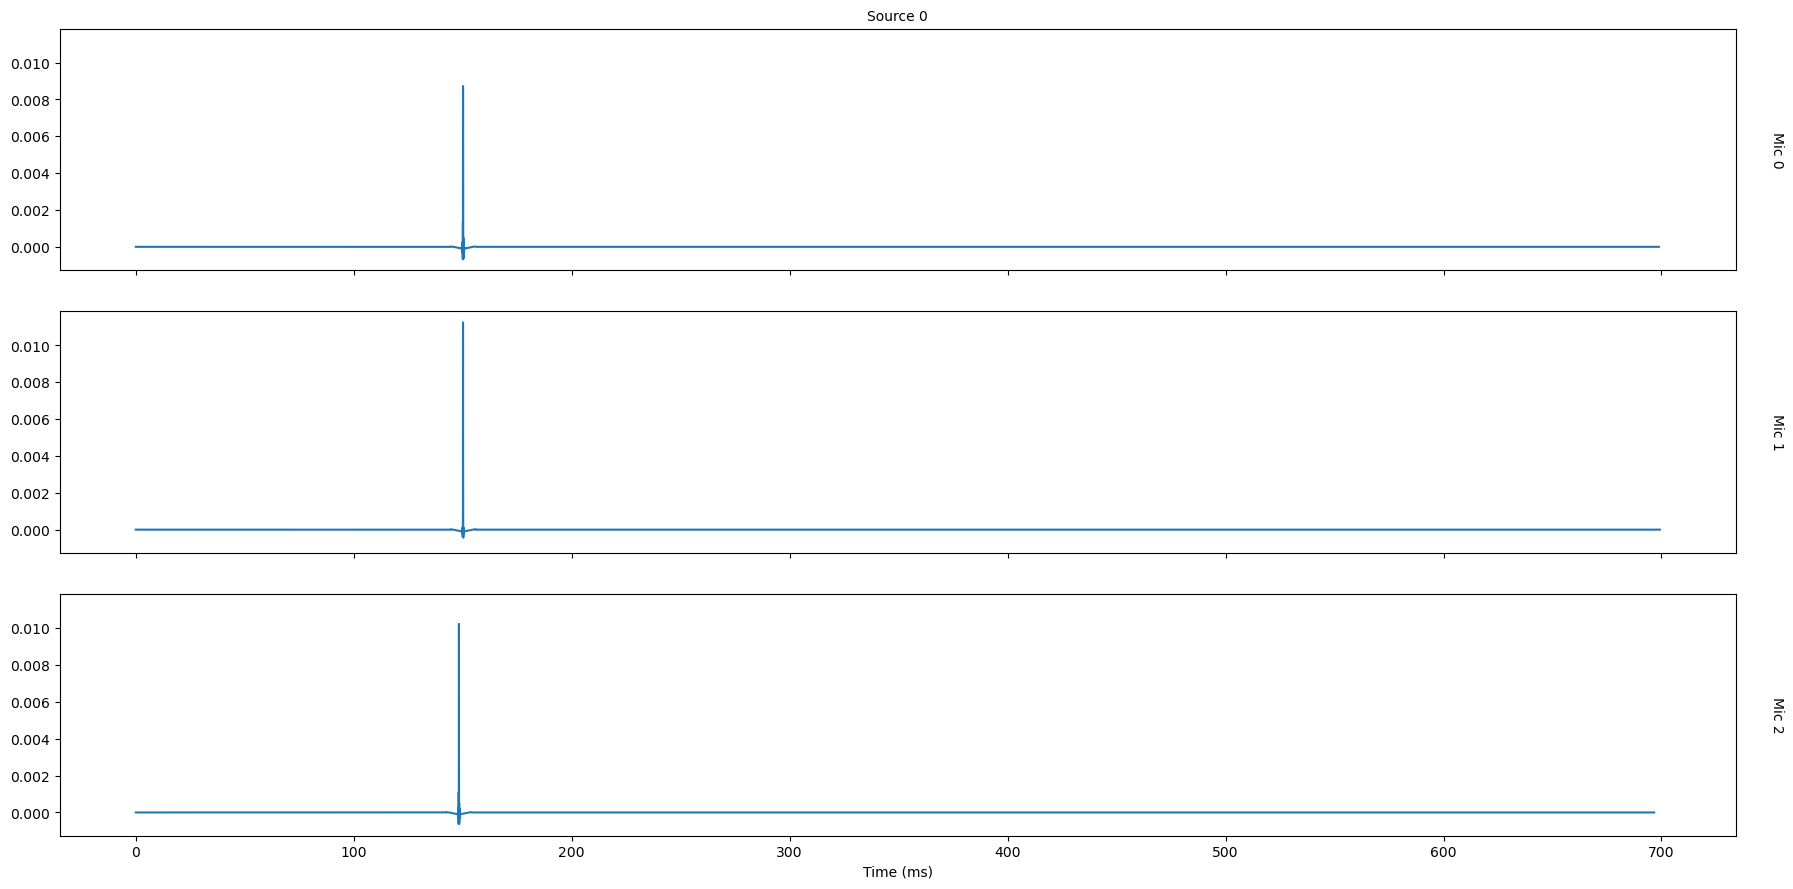

In [23]:
# Set wall materials for open field
wall_material = pra.Material(energy_absorption=1.0, scattering=0.0)
ceiling_material = pra.Material(energy_absorption=1.0, scattering=0.0)
floor_material = pra.Material(energy_absorption=0.05, scattering=0.25)

# Redefine room for 3D raytracing simulation.
room = pra.Room.from_corners(corners, fs=fs, max_order=5, materials=wall_material, ray_tracing=True, air_absorption=True)
room.extrude(h, materials=ceiling_material)
room.set_ray_tracing(receiver_radius=0.1, n_rays=10000, energy_thres=1e-7)
room.add_source(source)
room.add_microphone_array(pra.MicrophoneArray(mic_locs, fs=fs))

# Compute image sources
room.image_source_model()
room.plot_rir()
fig = plt.gcf()
fig.set_size_inches(20, 10)

t60 = pra.experimental.measure_rt60(room.rir[0][0], fs=room.fs, plot=False)
print(f"The RT60 is {t60 * 1000:.0f} ms")

C:\Users\David\AppData\Local\Temp\ipykernel_6688\1668044253.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, audio_noise = wavfile.read("noise.wav")


The desired RT60 was 0.3
The measured RT60 is 1.2831065759637188


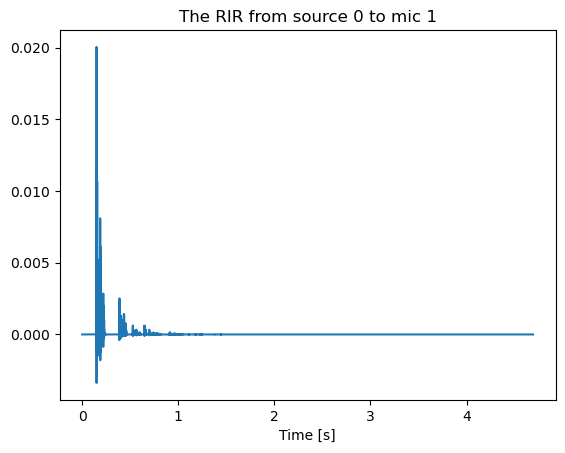

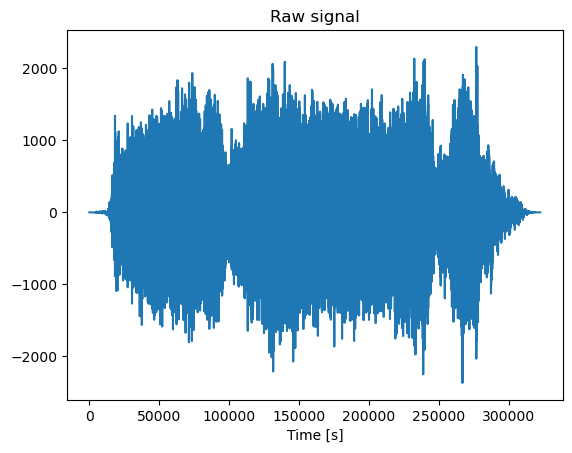

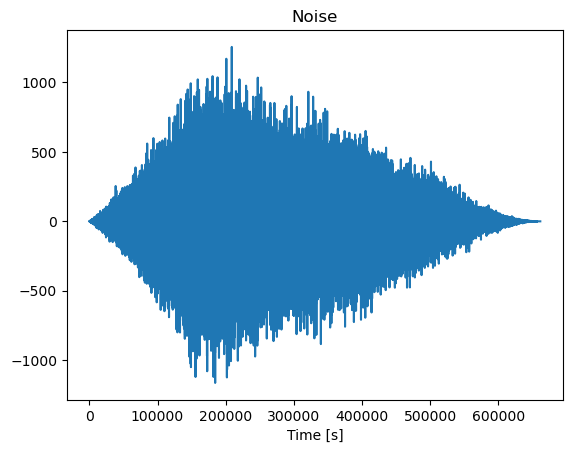

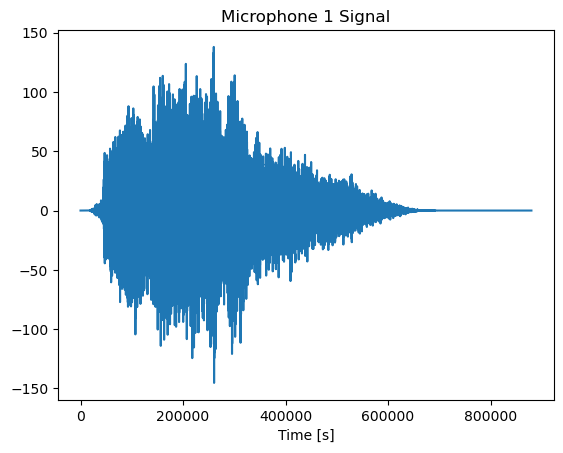

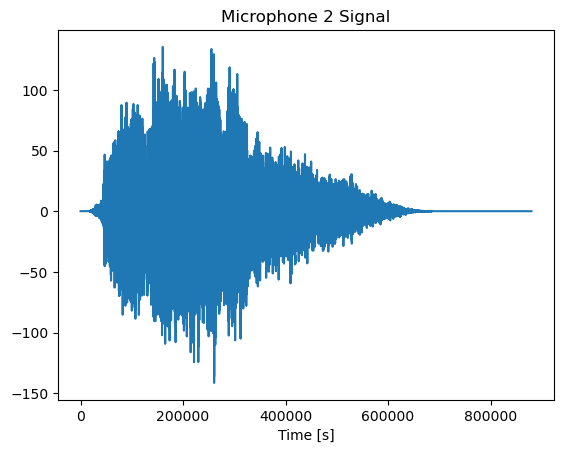

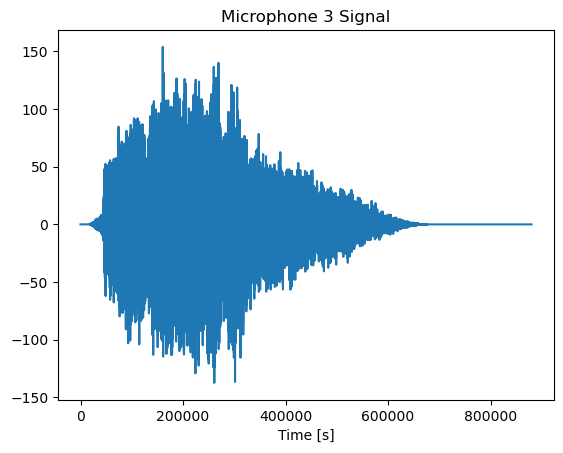

Unaltered Drone Sound: Normalized


Unaltered Noise Sound: Normalized


Microphone 1: Normalized


Microphone 2: Normalized


In [16]:
# The desired reverberation time and dimensions of the room
rt60_tgt = 0.3  # seconds
room_dim = [corner_locs,corner_locs,h] # meters

# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
fs, audio = wavfile.read("drone_audio.wav")
fs, audio_noise = wavfile.read("noise.wav")

# noise
noise = True
noise_attenuation = 0.05
audio_noise = audio_noise * noise_attenuation

if audio.ndim > 1:
    audio = np.mean(audio, axis=1)

if audio_noise.ndim > 1:
    audio_noise = np.mean(audio_noise, axis=1)

# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)


# Create the room
room = pra.ShoeBox(
    room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order
)


# place the source in the room
room.add_source(source, signal=audio, delay=0.5)
if noise:
  room.add_source(source_noise, signal=audio_noise, delay=0.25)


# finally place the array in the room
room.add_microphone_array(mic_locs)

# Run the simulation (this will also build the RIR automatically)
room.simulate()

"""
room.mic_array.to_wav(
    f"/content/mic_output.wav",
    norm=True,
    bitdepth=np.int16,
)
"""

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {}".format(rt60_tgt))
print("The measured RT60 is {}".format(rt60[1, 0]))

# Create a plot
plt.figure()

# plot one of the RIR. both can also be plotted using room.plot_rir()
rir_1_0 = room.rir[1][0]

plt.plot(np.arange(len(rir_1_0)) / room.fs, rir_1_0)
plt.title("The RIR from source 0 to mic 1")
plt.xlabel("Time [s]")
plt.show()

# plot signal at microphone 1

plt.plot(audio)
plt.title("Raw signal")
plt.xlabel("Time [s]")
plt.show()

plt.plot(audio_noise)
plt.title("Noise")
plt.xlabel("Time [s]")
plt.show()


plt.plot(room.mic_array.signals[0, :])
plt.title("Microphone 1 Signal")
plt.xlabel("Time [s]")
plt.show()

plt.plot(room.mic_array.signals[1, :])
plt.title("Microphone 2 Signal")
plt.xlabel("Time [s]")
plt.show()

plt.plot(room.mic_array.signals[2, :])
plt.title("Microphone 3 Signal")
plt.xlabel("Time [s]")
plt.show()



audio_data1 = room.mic_array.signals[0, :]
audio_data2 = room.mic_array.signals[1, :]
print("Unaltered Drone Sound: Normalized")
display(Audio(data=audio, rate=fs))
print("Unaltered Noise Sound: Normalized")
display(Audio(data=audio_noise, rate=fs))
print("Microphone 1: Normalized")
display(Audio(data=audio_data1, rate=fs))
print("Microphone 2: Normalized")
display(Audio(data=audio_data2, rate=fs))

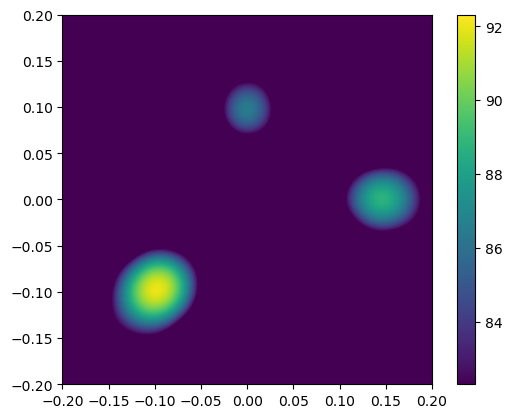

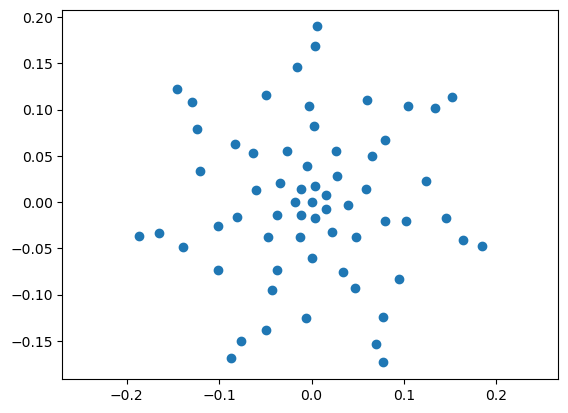

In [13]:
acoular.demo.acoular_demo.run()

Apt install follow gazebo and ROS2

In [17]:
import acoular
import numpy as np

# Use mic positions directly (shape must be (3, N))
mic_positions = room.mic_array.R  # shape: (3, num_mics)

mg = acoular.MicGeom()
mg.mpos_tot = mic_positions  # no need for .T, Acoular expects (3, N)

print("MicGeom initialized with", mg.num_mics, "mics")


MicGeom initialized with 3 mics


C:\Users\David\AppData\Local\Temp\ipykernel_6688\728217471.py:8: DeprecationWarning: Deprecated use of 'mpos_tot' trait. Please use the 'pos_total' trait instead.
  mg.mpos_tot = mic_positions  # no need for .T, Acoular expects (3, N)


In [19]:
import h5py

# Assuming `mic_signals` is a numpy array with shape (num_mics, num_samples)
mic_signals = room.mic_array.signals  # Or however you've stored it
sample_freq = fs  # or whatever you've used

with h5py.File('sim_signals.h5', 'w') as f:
    f.create_dataset('time_data', data=mic_signals.T)  # Transpose to shape (samples, channels)
    f.attrs['sample_freq'] = sample_freq


In [20]:
import h5py

with h5py.File('sim_signals.h5', 'r') as f:
    data = f['time_data']
    print("Shape of time_data:", data.shape)

Shape of time_data: (879724, 3)


In [21]:
import h5py

# Set your actual sampling frequency
SAMPLE_FREQ = fs  # or whatever value was used in Pyroomacoustics

with h5py.File("sim_signals.h5", "r+") as f:
    if 'time_data' in f:
        f['time_data'].attrs['sample_freq'] = SAMPLE_FREQ
        print("Added 'sample_freq' =", SAMPLE_FREQ)
    else:
        print("'/time_data' dataset not found.")

Added 'sample_freq' = 44100


C:\Users\David\AppData\Local\Temp\ipykernel_6688\3023563011.py:6: DeprecationWarning: Deprecated use of 'name' trait. Please use the 'file' trait instead.
  ts = ac.TimeSamples(name='sim_signals.h5')


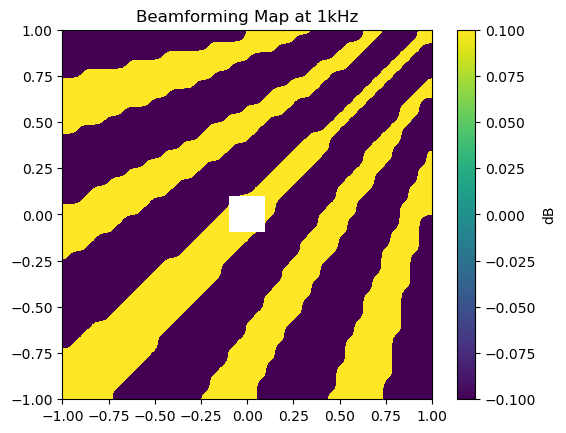

In [22]:
from pathlib import Path
import acoular as ac
import matplotlib.pyplot as plt

# Load mic geometry and signals
ts = ac.TimeSamples(name='sim_signals.h5')
ps = ac.PowerSpectra(source=ts, block_size=128, window='Hanning')

# Define scanning grid around expected source location
rg = ac.RectGrid(x_min=-1, x_max=1, y_min=-1, y_max=1, z=0, increment=0.05)
st = ac.SteeringVector(grid=rg, mics=mg)
bb = ac.BeamformerBase(freq_data=ps, steer=st)

# Beamform at a selected frequency (e.g., 8000 Hz)
pm = bb.synthetic(1000, 3)
Lm = ac.L_p(pm)

plt.imshow(Lm.T, origin='lower', vmin=Lm.max()-10, extent=rg.extend(), interpolation='bicubic')
plt.title("Beamforming Map at 1kHz")
plt.colorbar(label='dB')
plt.show()
